# 1. Dataset Preparation

In [47]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import random

In [48]:
data = [
    # Positive
    ("I love this movie, it was fantastic!", 1),
    ("Amazing plot and great performances!", 1),
    ("What a wonderful experience!", 1),
    ("Brilliant direction and strong cast.", 1),
    ("Absolutely loved it!", 1),
    ("A masterpiece of modern cinema.", 1),
    ("The visuals and story were breathtaking.", 1),
    ("Exceptional acting and brilliant screenplay.", 1),
    ("Truly inspiring and well-crafted.", 1),
    ("An emotional rollercoaster with a happy end.", 1),
    ("The movie exceeded my expectations.", 1),
    ("I enjoyed every minute of it.", 1),
    ("Heartwarming and deeply moving.", 1),
    ("A compelling story with great characters.", 1),
    ("The actors delivered fantastic performances.", 1),
    ("An unforgettable experience.", 1),
    ("The direction was top-notch.", 1),
    ("Highly entertaining and beautifully shot.", 1),
    ("Best movie I've seen this year!", 1),
    ("Wonderful execution and pacing.", 1),
    ("Left me speechless, in a good way.", 1),
    ("Incredible storytelling and visuals.", 1),
    ("Uplifting and inspiring movie.", 1),
    ("A joy to watch from start to finish.", 1),
    ("Loved the soundtrack and cinematography.", 1),
    ("Totally worth watching again!", 1),
    ("The dialogue was witty and smart.", 1),
    ("Very touching and well-acted.", 1),
    ("The characters felt very real and human.", 1),
    ("A fresh and original take on a familiar genre.", 1),
    ("The chemistry between the leads was amazing.", 1),
    ("Impressive production quality and plot depth.", 1),
    ("Simply stunning and emotionally satisfying.", 1),
    ("Loved the twists and turns.", 1),
    ("This film deserves all the praise.", 1),
    ("I was completely immersed.", 1),
    ("It was okay, not the best but enjoyable.", 1),
    ("Pleasantly surprised by how good it was.", 1),
    ("A solid movie night pick.", 1),
    ("Engaging and thoughtful throughout.", 1),
    ("I smiled through most of the film.", 1),
    ("Definitely recommend this movie.", 1),
    ("A positive and feel-good story.", 1),
    ("An all-time favorite!", 1),
    ("Five stars from me!", 1),
    ("A nice blend of humor and emotion.", 1),
    ("Very entertaining.", 1),
    ("One of the better films this year.", 1),
    ("Charming and full of heart.", 1),
    ("Didn't expect to love it this much.", 1),

    # Negative
    ("Absolutely terrible. Waste of time.", 0),
    ("Worst acting I have ever seen.", 0),
    ("I didn't like it at all.", 0),
    ("The film was boring and predictable.", 0),
    ("Horrible. I walked out halfway.", 0),
    ("A complete disaster from start to finish.", 0),
    ("Terribly written and poorly executed.", 0),
    ("The plot made no sense.", 0),
    ("A mess of clichés and bad dialogue.", 0),
    ("Not worth the hype.", 0),
    ("It was painful to sit through.", 0),
    ("The pacing was way off.", 0),
    ("Characters were flat and uninteresting.", 0),
    ("Too many plot holes to count.", 0),
    ("Acting was wooden and emotionless.", 0),
    ("An insult to the genre.", 0),
    ("Predictable and lazy writing.", 0),
    ("Music was distracting and out of place.", 0),
    ("Uninspired and forgettable.", 0),
    ("Dialogue felt forced and unnatural.", 0),
    ("It dragged on forever.", 0),
    ("Couldn’t connect with any character.", 0),
    ("The trailer was better than the movie.", 0),
    ("Disappointing and dull.", 0),
    ("Felt like a waste of money.", 0),
    ("The jokes were cringe-worthy.", 0),
    ("It lacked depth and originality.", 0),
    ("Too predictable and not funny.", 0),
    ("Very slow and uninteresting plot.", 0),
    ("Nothing happened for an hour.", 0),
    ("Really bad camera work and sound.", 0),
    ("The ending was abrupt and made no sense.", 0),
    ("Failed to deliver any emotion.", 0),
    ("Overacted and overhyped.", 0),
    ("Not even good for background noise.", 0),
    ("Terribly boring.", 0),
    ("I regret watching it.", 0),
    ("Very disappointing.", 0),
    ("One of the worst films I've seen.", 0),
    ("Unbelievably bad.", 0),
    ("A total flop.", 0),
    ("The cast seemed confused.", 0),
    ("The story didn’t go anywhere.", 0),
    ("I almost fell asleep.", 0),
    ("Nothing redeeming about it.", 0),
    ("It tried too hard to be deep.", 0),
    ("Just plain bad.", 0),
    ("I wanted to leave early.", 0),
    ("Bad acting, worse writing.", 0),
    ("Complete waste of time.", 0),
]


In [49]:
random.shuffle(data)  # to ensure randomness in train-test split

### Tokenizer:

 - Converts a sentence like "I love this movie" → ["i", "love", "this", "movie"].
 - split text to tokens, so that tokens can be converted to numbers

### Vocabulary:

- mapping of each unique token to a number
- vocab = {"<PAD>": 0, "<UNK>": 1, "i": 2, "love": 3, ...}
- vocab size = len(vocab), used by nn.Embedding to know how many unique word vectors to learn.

In [50]:
# Basic tokenizer
def tokenize(text):
    return text.lower().replace('.', '').replace(',', '').split()

In [51]:
# Build vocabulary
vocab = {"<PAD>": 0, "<UNK>": 1}
for text, _ in data:
    for token in tokenize(text):    # call above function to remove unnecessary characters
        if token not in vocab:
            vocab[token] = len(vocab)

In [52]:
len(vocab)   # unique tokens (including pad and unk)

275

### Encode:

- Converts ["i", "love", "this", "movie"] → [2, 3, 4, 5, 0, 0, 0, 0, 0, 0] (fixed length of 10).



In [53]:
# Encode text to fixed-length tensor
def encode(text, max_len=10):
    tokens = tokenize(text)      # for any incoming text (dataset or inference texts)
    ids = [vocab.get(token, vocab["<UNK>"]) for token in tokens]  # if token exists in vocab, get its ID
    ids = ids[:max_len] + [vocab["<PAD>"]] * (max_len - len(ids))   # pad or truncate the list
    return torch.tensor(ids)

In [54]:
# Custom Dataset
class SentimentDataset(Dataset):
    def __init__(self, data, max_len=10):
        self.samples = data
        self.max_len = max_len

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        text, label = self.samples[idx]
        return encode(text, self.max_len), torch.tensor(label)

In [55]:
# Train-test-validation split(80:10:10)
max_len = 10
train_data = data[:int(0.8 * len(data))]
val_data=data[int(0.8 * len(data)):int(0.9 * len(data))]
test_data = data[int(0.9 * len(data)):]
train_loader = DataLoader(SentimentDataset(train_data, max_len), batch_size=2, shuffle=True)
val_loader = DataLoader(SentimentDataset(val_data, max_len), batch_size=2,shuffle=True)
test_loader = DataLoader(SentimentDataset(test_data, max_len), batch_size=2)


# 2. Model Building:

### Embedding layers: learns to map each token ID to dense vector

In [56]:
# Simple Feedforward Model
class FeedForwardModel(nn.Module):
    def __init__(self, vocab_size, embed_dim=16, hidden_dim=8):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.fc1 = nn.Linear(embed_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 2)

    def forward(self, x):
        embedded = self.embedding(x)                # (batch, seq_len, embed_dim)
        pooled = embedded.mean(dim=1)               # Mean pooling over sequence
        out = torch.relu(self.fc1(pooled))
        return self.fc2(out)

In [57]:
# LSTM-based Model
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, max_len):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, 100)      # 275 words(vocab) x 100 dim vector each
        self.lstm = nn.LSTM(100, 100, batch_first=True)     # new layer (lstm)
        self.fc1 = nn.Linear(100 * max_len, 50)
        self.fc2 = nn.Linear(50, 2)

    def forward(self, x):
        x = self.embedding(x)                       # (batch, seq_len, 100)
        x, _ = self.lstm(x)                         # LSTM output
        x = torch.relu(x)
        x = x.reshape(x.size(0), -1)                # Flatten (batch, 100 * seq_len)
        x = torch.relu(self.fc1(x))                 # Dense layer
        return self.fc2(x)


# 3. Training Loop
## 3.a. Useful functions:

In [58]:
def train_model(model, train_loader,val_loader ,criterion, optimizer, num_epochs=10):
    loss_values, accuracy_values = [], []

    for epoch in range(num_epochs):
        model.train()
        total_loss, all_preds, all_labels = 0, [], []

        for texts, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(texts)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.tolist())
            all_labels.extend(labels.tolist())

        avg_loss = total_loss / len(train_loader)
        accuracy = accuracy_score(all_labels, all_preds)
        loss_values.append(avg_loss)
        accuracy_values.append(accuracy)



        #For validation dataset
        model.eval()
        val_loss, val_preds, val_labels = 0, [], []
        with torch.no_grad():
            for texts,labels in val_loader:
                outputs=model(texts)
                loss=criterion(outputs,labels)
                val_loss+=loss.item()
                preds=torch.argmax(outputs,dim=1)
                val_preds.extend(preds.tolist())
                val_labels.extend(labels.tolist())
        val_accuracy=accuracy_score(val_labels,val_preds)
        val_loss/=len(val_loader)



        print(f"Epoch {epoch+1}/{num_epochs} | Loss: {avg_loss:.4f} | Accuracy: {accuracy:.4f}")
        print(f"Validation Loss: {val_loss:.4f} | Validation Accuracy: {val_accuracy:.4f}")

    return loss_values, accuracy_values

In [59]:
def evaluate_model(model, test_loader):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for texts, labels in test_loader:
            outputs = model(texts)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.tolist())
            all_labels.extend(labels.tolist())

    print("Test Accuracy:", accuracy_score(all_labels, all_preds))
    print(classification_report(all_labels, all_preds, target_names=["Negative", "Positive"]))


In [60]:
def plot_training(losses, accuracies, title="Model Performance"):
    plt.figure(figsize=(12,5))

    # Plot loss
    plt.subplot(1,2,1)
    plt.plot(losses, label="Loss", color='blue')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss vs Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1,2,2)
    plt.plot(accuracies, label="Accuracy", color='green')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Accuracy vs Epochs")
    plt.legend()

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

## 3.b. Using above functions for Model 1

In [61]:
ff_model = FeedForwardModel(vocab_size=len(vocab))

In [62]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(ff_model.parameters(), lr=0.001)

In [63]:
losses_ff, accs_ff = train_model(ff_model, train_loader,val_loader, criterion, optimizer, num_epochs=20)


Epoch 1/20 | Loss: 0.6914 | Accuracy: 0.5625
Validation Loss: 0.7110 | Validation Accuracy: 0.3000
Epoch 2/20 | Loss: 0.6870 | Accuracy: 0.5625
Validation Loss: 0.7101 | Validation Accuracy: 0.5000
Epoch 3/20 | Loss: 0.6832 | Accuracy: 0.5875
Validation Loss: 0.7138 | Validation Accuracy: 0.4000
Epoch 4/20 | Loss: 0.6786 | Accuracy: 0.5875
Validation Loss: 0.7173 | Validation Accuracy: 0.4000
Epoch 5/20 | Loss: 0.6735 | Accuracy: 0.6000
Validation Loss: 0.7200 | Validation Accuracy: 0.4000
Epoch 6/20 | Loss: 0.6683 | Accuracy: 0.6125
Validation Loss: 0.7232 | Validation Accuracy: 0.4000
Epoch 7/20 | Loss: 0.6611 | Accuracy: 0.6250
Validation Loss: 0.7295 | Validation Accuracy: 0.3000
Epoch 8/20 | Loss: 0.6540 | Accuracy: 0.6500
Validation Loss: 0.7317 | Validation Accuracy: 0.4000
Epoch 9/20 | Loss: 0.6455 | Accuracy: 0.6625
Validation Loss: 0.7393 | Validation Accuracy: 0.4000
Epoch 10/20 | Loss: 0.6359 | Accuracy: 0.6500
Validation Loss: 0.7442 | Validation Accuracy: 0.4000
Epoch 11/

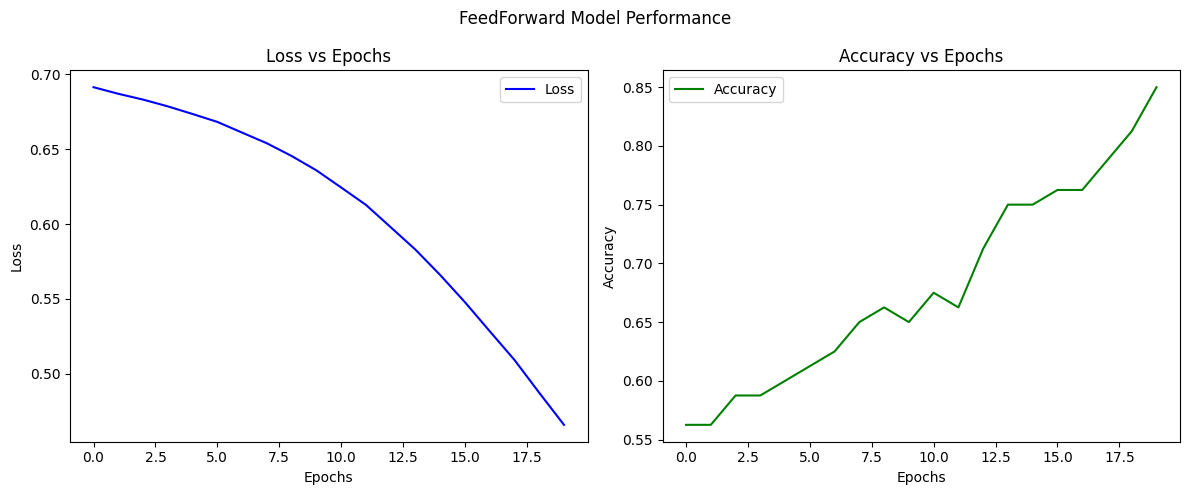

In [64]:
plot_training(losses_ff, accs_ff, title="FeedForward Model Performance")


In [65]:
evaluate_model(ff_model, test_loader)


Test Accuracy: 0.3
              precision    recall  f1-score   support

    Negative       0.20      0.25      0.22         4
    Positive       0.40      0.33      0.36         6

    accuracy                           0.30        10
   macro avg       0.30      0.29      0.29        10
weighted avg       0.32      0.30      0.31        10



## 3.c. Using above functions for Model 2

In [66]:
lstm_model = LSTMModel(vocab_size=len(vocab), max_len=max_len)

In [67]:
criterion_lstm = nn.CrossEntropyLoss()
optimizer_lstm = torch.optim.Adam(lstm_model.parameters(), lr=0.001)

In [68]:
losses_lstm, accs_lstm = train_model(lstm_model, train_loader,val_loader, criterion_lstm, optimizer_lstm, num_epochs=20)


Epoch 1/20 | Loss: 0.7064 | Accuracy: 0.5250
Validation Loss: 0.7251 | Validation Accuracy: 0.2000
Epoch 2/20 | Loss: 0.6550 | Accuracy: 0.6625
Validation Loss: 0.7281 | Validation Accuracy: 0.2000
Epoch 3/20 | Loss: 0.4363 | Accuracy: 0.9000
Validation Loss: 0.5698 | Validation Accuracy: 0.7000
Epoch 4/20 | Loss: 0.1090 | Accuracy: 0.9750
Validation Loss: 0.4559 | Validation Accuracy: 0.9000
Epoch 5/20 | Loss: 0.0111 | Accuracy: 1.0000
Validation Loss: 0.5534 | Validation Accuracy: 0.6000
Epoch 6/20 | Loss: 0.0033 | Accuracy: 1.0000
Validation Loss: 0.4453 | Validation Accuracy: 0.8000
Epoch 7/20 | Loss: 0.0012 | Accuracy: 1.0000
Validation Loss: 0.4601 | Validation Accuracy: 0.8000
Epoch 8/20 | Loss: 0.0008 | Accuracy: 1.0000
Validation Loss: 0.4725 | Validation Accuracy: 0.8000
Epoch 9/20 | Loss: 0.0005 | Accuracy: 1.0000
Validation Loss: 0.4789 | Validation Accuracy: 0.8000
Epoch 10/20 | Loss: 0.0004 | Accuracy: 1.0000
Validation Loss: 0.4902 | Validation Accuracy: 0.8000
Epoch 11/

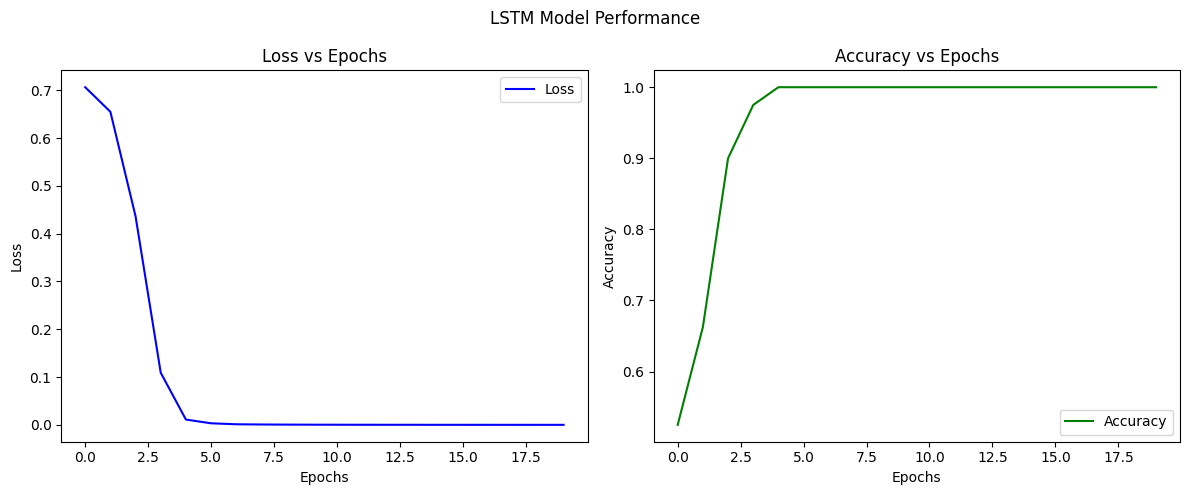

In [69]:
plot_training(losses_lstm, accs_lstm, title="LSTM Model Performance")


In [70]:
evaluate_model(lstm_model, test_loader)

Test Accuracy: 0.5
              precision    recall  f1-score   support

    Negative       0.33      0.25      0.29         4
    Positive       0.57      0.67      0.62         6

    accuracy                           0.50        10
   macro avg       0.45      0.46      0.45        10
weighted avg       0.48      0.50      0.48        10

